# Overview

The motive of this step was to explore the data provided in the AWS S3 bucket and figure out the characteristics of training and validation data. This helped in the following tasks:

* What the augmentation strategy should look like
* How similar or different the validation data is from the training set data. This sets up a baseline expectations for the performance of the trained model.

## Setting up the Enviroment

Since the data provided by Udacity was stored in an AWS S3 bucket, the first step was to setup AWS CLI to download the data locally for further exploration purposes.

The instructions to setup the CLI can be found here: https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html

The fastest and simplest approach is to create a temporary key-value pair in the AWS console to be used with the `aws s3 cp` command and add it to local aws config file. Although it is not the recommended approach, it's quicker and safe enough if you delete the generate key-value pair after its use.

In [127]:
from PIL import Image
import tensorflow as tf

## Downloading the Data

In [128]:
import os

# S3 and local paths for the train and validation tfrecords file
region = "us-east-1"

train_data_remote_path = "s3://cd2688-object-detection-tf2/train/"
train_data_download_path = os.path.join(os.getcwd(), "train")

validation_data_remote_path = "s3://cd2688-object-detection-tf2/val/"
validation_data_download_path = os.path.join(os.getcwd(), "val")

In [64]:
!echo "Starting to download training data at {train_data_download_path}"
!aws s3 cp {train_data_remote_path} {train_data_download_path} --recursive --region {region}

Starting to download training data at /Users/rajdeep1008/self-driving-nd/cd2688-object-detection-in-urban-environment-project/project_writeup/Exploratory-Data-Analysis/train
download: s3://cd2688-object-detection-tf2/train/label_map.pbtxt to train/label_map.pbtxt
download: s3://cd2688-object-detection-tf2/train/segment-10094743350625019937_3420_000_3440_000_with_camera_labels.tfrecord to train/segment-10094743350625019937_3420_000_3440_000_with_camera_labels.tfrecord
download: s3://cd2688-object-detection-tf2/train/segment-10072231702153043603_5725_000_5745_000_with_camera_labels.tfrecord to train/segment-10072231702153043603_5725_000_5745_000_with_camera_labels.tfrecord
download: s3://cd2688-object-detection-tf2/train/segment-10082223140073588526_6140_000_6160_000_with_camera_labels.tfrecord to train/segment-10082223140073588526_6140_000_6160_000_with_camera_labels.tfrecord
download: s3://cd2688-object-detection-tf2/train/segment-10153695247769592104_787_000_807_000_with_camera_labels

In [65]:
!echo "Starting to download validation data at {validation_data_download_path}"
!aws s3 cp {validation_data_remote_path} {validation_data_download_path} --recursive --region {region}

Starting to download validation data at /Users/rajdeep1008/self-driving-nd/cd2688-object-detection-in-urban-environment-project/project_writeup/Exploratory-Data-Analysis/val
download: s3://cd2688-object-detection-tf2/val/label_map.pbtxt to val/label_map.pbtxt
download: s3://cd2688-object-detection-tf2/val/segment-12012663867578114640_820_000_840_000_with_camera_labels.tfrecord to val/segment-12012663867578114640_820_000_840_000_with_camera_labels.tfrecord
download: s3://cd2688-object-detection-tf2/val/segment-12161824480686739258_1813_380_1833_380_with_camera_labels.tfrecord to val/segment-12161824480686739258_1813_380_1833_380_with_camera_labels.tfrecord
download: s3://cd2688-object-detection-tf2/val/segment-12027892938363296829_4086_280_4106_280_with_camera_labels.tfrecord to val/segment-12027892938363296829_4086_280_4106_280_with_camera_labels.tfrecord
download: s3://cd2688-object-detection-tf2/val/segment-1208303279778032257_1360_000_1380_000_with_camera_labels.tfrecord to val/segm

In [129]:
training_files = os.listdir(train_data_download_path)
training_files = [os.path.join(train_data_download_path, fname) for fname in training_files if fname.endswith("tfrecord")]
print(f"Total training files downloaded: {len(training_files)}")

validation_files = os.listdir(validation_data_download_path)
validation_files = [os.path.join(validation_data_download_path, fname) for fname in validation_files if fname.endswith("tfrecord")]
print(f"Total validation files downloaded: {len(validation_files)}")

Total training files downloaded: 84
Total validation files downloaded: 13


## Converting to a Human-Readable Format
 
The data provided is divided into multiple files, each in the `tfrecord` format following the requirements mentioned by TF object detection API.

So the next step are:
1. Parse `encoded images` and `class labels` for each of the tfrecords
2. Convert the images from byte string to jpeg and write them in a folder so that they can be visualized
3. Chart the distribution of the predicted ground-truth classes

In [130]:
raw_training_dataset = tf.data.TFRecordDataset(training_files)
raw_validation_dataset = tf.data.TFRecordDataset(validation_files)

# features mapping for the required image and labels data
feature_description = {
    "image/object/class/label": tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
    "image/encoded": tf.io.FixedLenSequenceFeature([], tf.string, allow_missing=True),
}

def parse_raw_dataset(proto_item):
    return tf.io.parse_single_example(proto_item, feature_description)

In [131]:
parsed_training_dataset = raw_training_dataset.map(parse_raw_dataset)
parsed_validation_dataset = raw_validation_dataset.map(parse_raw_dataset)

# the images gets stored in numpy array format and the classes as integers in a list
train_images = []
train_classes = []

validation_images = []
validation_classes = []

for item in parsed_training_dataset:
    img = tf.io.decode_jpeg(item["image/encoded"].numpy()[0]).numpy()
    label = item["image/object/class/label"].numpy()
    
    train_images.append(img)
    train_classes.append(label)

for item in parsed_validation_dataset:
    img = tf.io.decode_jpeg(item["image/encoded"].numpy()[0]).numpy()
    label = item["image/object/class/label"].numpy()

    validation_images.append(img)
    validation_classes.append(label)

print(f"Total training images: {len(train_images)}")
print(f"Total validation images: {len(validation_images)}")

Total training images: 1679
Total validation images: 258


In [120]:
# Creates images from the numpy arrays and store them as jpeg
if not os.path.isdir("train_images"):
    os.mkdir("train_images")

if not os.path.isdir("val_images"):
    os.mkdir("val_images")

# this will create a gif for quick visualization
training_gif = []
validation_gif = []

for idx, img in enumerate(train_images):
    img = Image.fromarray(img)
    img.save(f"./train_images/{idx}.jpg")
    training_gif.append(img)

for idx, img in enumerate(validation_images):
    img = Image.fromarray(img)
    img.save(f"./val_images/{idx}.jpg")
    validation_gif.append(img)

In [ ]:
# Creating a gif out of all the images for easy viewing.
# Right click the created gif and open in a browser for easy viewing exp.

# this will take a few minutes since the final file is around ~450mb in size
training_gif[0].save("training.gif", save_all=True, optimize=False, append_images=training_gif[1:], loop=0)

In [121]:
validation_gif[0].save("validation.gif", save_all=True, optimize=False, append_images=validation_gif[1:], loop=0)

## Basic EDA

I've compared the distribution of type of classes in both the validation and training datasets. This provides a basic idea about the distribution of objects.

In [143]:
# Given mapping of the labels and classes
mapping = {
    "1": "vehicle",
    "2": "pedestrian",
    "4": "cyclist",
}

In [148]:
training_class_count_mapping = {
    "1": 0,
    "2": 0,
    "4": 0,
}
validation_class_count_mapping = {
    "1": 0,
    "2": 0,
    "4": 0,
}

for item_arr in train_classes:
    for item in item_arr:
        training_class_count_mapping[str(item)] = training_class_count_mapping[str(item)] + 1

for item_arr in validation_classes:
    for item in item_arr:
        validation_class_count_mapping[str(item)] = validation_class_count_mapping[str(item)] + 1

train_labels_final = [mapping[class_label] for (class_label, count) in list(training_class_count_mapping.items())]
train_dist_counts = [count for (class_label, count) in list(training_class_count_mapping.items())]

val_labels_final = [mapping[class_label] for (class_label, count) in list(validation_class_count_mapping.items())]
val_dist_counts = [count for (class_label, count) in list(validation_class_count_mapping.items())]

In [141]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Object type distribution in Training data set')

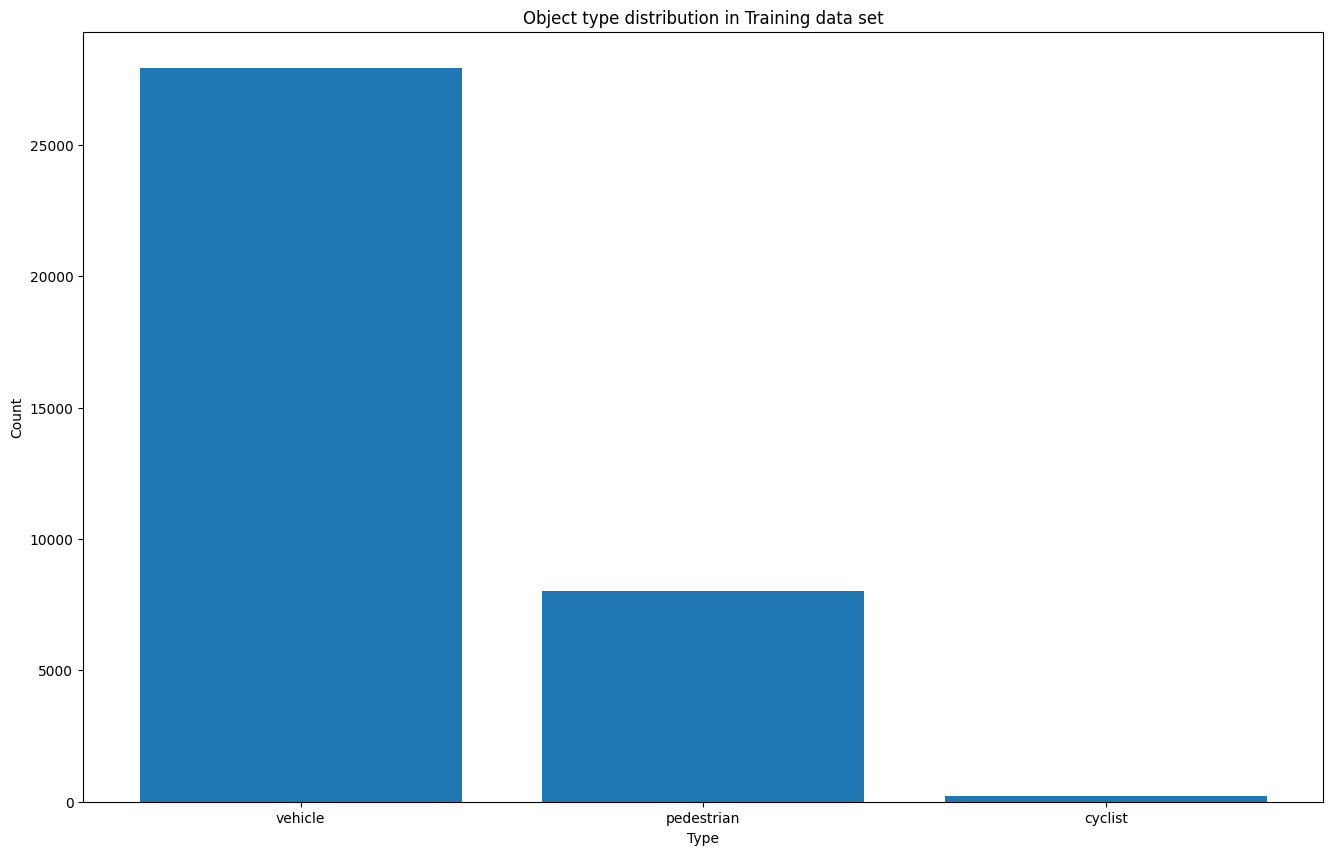

In [153]:
# Training data class distribution

plt.figure(figsize=(16,10))
plt.bar(train_labels_final, train_dist_counts)
plt.xlabel("Type")
plt.ylabel("Count")
plt.title("Object type distribution in Training data set")

Text(0.5, 1.0, 'Object type distribution in Validation data set')

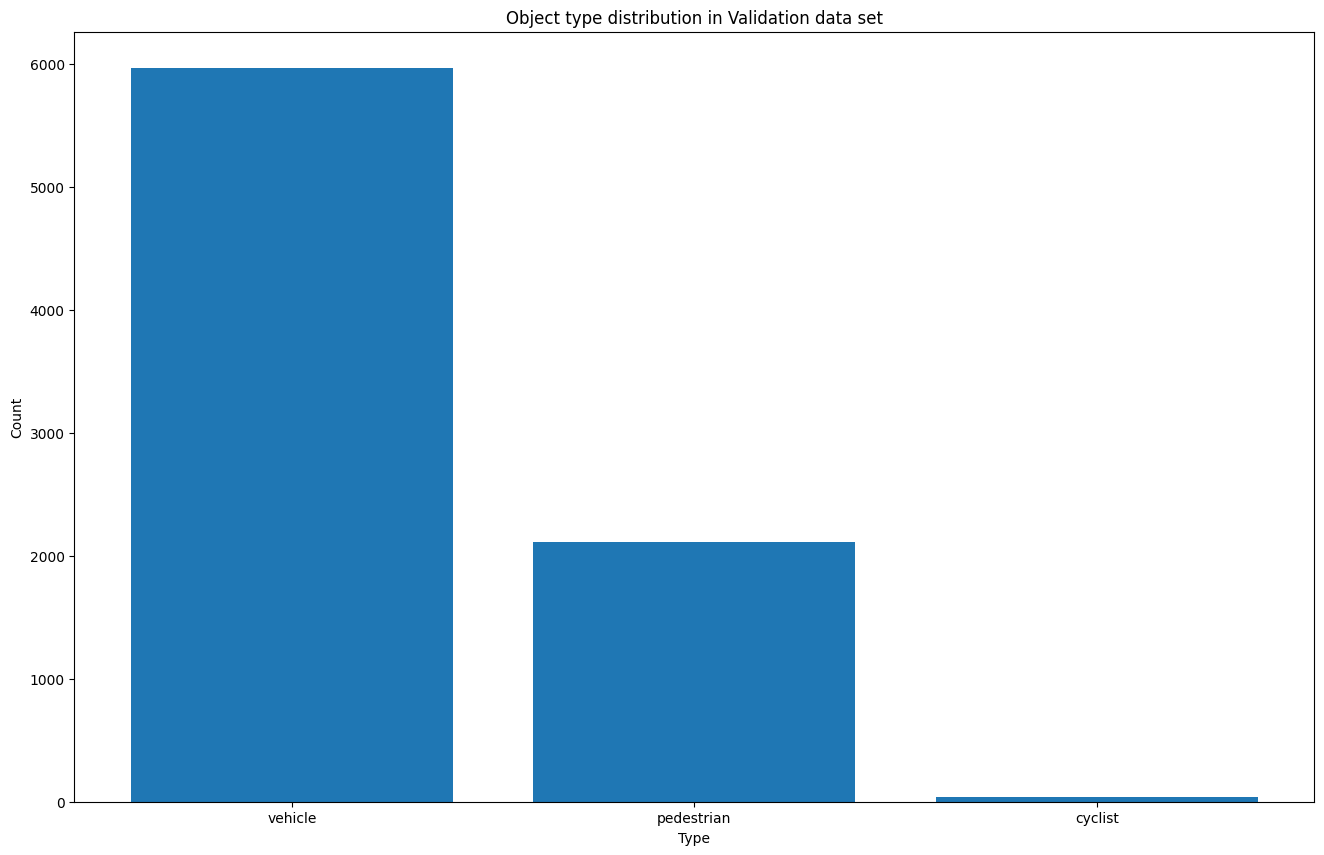

In [154]:
# Validation data class distribution

plt.figure(figsize=(16,10))
plt.bar(val_labels_final, val_dist_counts)
plt.xlabel("Type")
plt.ylabel("Count")
plt.title("Object type distribution in Validation data set")

## Remarks

### Understanding from the plots

* The number of detected vehicles in the given data segments is almost 3x of pedestrians. The number of cyclists are very less as compared to the other two types.
* Validation and Training data follows the same trend which means that the model should be able to generalize on the validation set well.
* This sets up a tone about the shape of training anchors for bounding box regression which I further explore in the model improvements section.

### Observations from the Training images

* Training segments had a good mixture of day and night scenes
* A lot of them had harsh rainy weather drives where camera was covered with water drops, mist and watery occlusions
* Some places had construction going on along some really tight driving spots
* Some of the freeway drives had a direct sunlight glare on the camera lens causing the images to be extremely bright
* Images where it was raining during night time might turn out challenging
 
### Observations from the Validation images

* Validation images also had a decent mixture of day and night scenes
* The weather wasn't as rainy as that of the training dataset
* Some images with camera sunlight glares where present too